In [20]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest

In [ ]:
def load_and_prepare_raw_data(file_path):
    print(f"Reading the raw transaction data from: {file_path}")
    with open(file_path, 'r') as file:
        raw_data = json.load(file)

    # The json_normalize function is perfect for flattening nested data.
    transactions_dataframe = pd.json_normalize(raw_data, sep='_')
    print("Successfully flattened the JSON data into a DataFrame.")

    # We select only the columns that hold the information we need.
    essential_columns = [
        'userWallet', 'timestamp', 'action',
        'actionData_amount', 'actionData_assetPriceUSD', 'actionData_assetSymbol'
    ]
    transactions_dataframe = transactions_dataframe[essential_columns]

    # Let's convert our data into the right formats for analysis.
    transactions_dataframe['timestamp'] = pd.to_datetime(transactions_dataframe['timestamp'], unit='s')
    transactions_dataframe['actionData_amount'] = pd.to_numeric(transactions_dataframe['actionData_amount'], errors='coerce')
    transactions_dataframe['actionData_assetPriceUSD'] = pd.to_numeric(transactions_dataframe['actionData_assetPriceUSD'], errors='coerce')

    # A crucial step: calculating the value of each transaction in a common unit (USD).
    # We handle potential missing price data gracefully.
    transactions_dataframe['transaction_value_in_usd'] = transactions_dataframe['actionData_amount'] * transactions_dataframe['actionData_assetPriceUSD']
    transactions_dataframe.fillna({'transaction_value_in_usd': 0}, inplace=True)

    return transactions_dataframe

# --- Let's run the function ---
input_file_path = 'user-wallet-transactions.json'
raw_transactions = load_and_prepare_raw_data(input_file_path)

print("\nHere's a sample of our cleaned transaction data:")
print(raw_transactions.head())

Reading the raw transaction data from: /content/user-wallet-transactions.json
Successfully flattened the JSON data into a DataFrame.

Here's a sample of our cleaned transaction data:
                                   userWallet           timestamp  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6 2021-08-17 05:29:26   
1  0x000000000051d07a4fb3bd10121a343d85818da6 2021-05-20 15:36:53   
2  0x000000000096026fb41fc39f9875d164bd82e2dc 2021-07-24 09:28:33   
3  0x000000000096026fb41fc39f9875d164bd82e2dc 2021-07-31 23:15:18   
4  0x0000000000e189dd664b9ab08a33c4839953852c 2021-04-19 15:25:07   

             action  actionData_amount  actionData_assetPriceUSD  \
0           deposit       2.000000e+09                  0.993832   
1           deposit       1.450000e+20                  1.970307   
2           deposit       1.000000e+15                  0.922377   
3           deposit       4.000000e+15                  1.057483   
4  redeemunderlying       5.015480e+05                  1.0021

In [22]:
def create_wallet_profiles(transactions_df):
    print("\nStarting the feature engineering process to build wallet profiles...")

    # We sort by wallet and time to properly analyze sequences of actions.
    transactions_df = transactions_df.sort_values(by=['userWallet', 'timestamp'])

    # First, let's gather basic activity and loyalty metrics.
    wallet_profiles = transactions_df.groupby('userWallet').agg(
        first_seen_on=('timestamp', 'min'),
        last_seen_on=('timestamp', 'max'),
        total_number_of_transactions=('timestamp', 'count')
    ).reset_index()

    wallet_profiles['wallet_activity_duration_days'] = (wallet_profiles['last_seen_on'] - wallet_profiles['first_seen_on']).dt.days
    wallet_profiles['transactions_per_day'] = wallet_profiles['total_number_of_transactions'] / (wallet_profiles['wallet_activity_duration_days'] + 1)

    # Now, let's count the different types of actions each wallet performed.
    action_type_counts = transactions_df.pivot_table(index='userWallet', columns='action', aggfunc='size', fill_value=0)

    # Let's also sum the USD value for each action type. This shows financial scale.
    action_usd_value_sum = transactions_df.pivot_table(index='userWallet', columns='action', values='transaction_value_in_usd', aggfunc='sum', fill_value=0)
    action_usd_value_sum.columns = [f'{col}_total_usd_value' for col in action_usd_value_sum.columns]

    # To detect bots vs. humans, let's analyze the time between transactions.
    transactions_df['time_since_previous_transaction_seconds'] = transactions_df.groupby('userWallet')['timestamp'].diff().dt.total_seconds().fillna(0)
    timing_analysis = transactions_df.groupby('userWallet')['time_since_previous_transaction_seconds'].agg(['mean', 'std']).fillna(0)
    timing_analysis.columns = ['average_time_between_transactions', 'std_dev_time_between_transactions']

    # Finally, how diverse is the wallet's activity?
    asset_diversity = transactions_df.groupby('userWallet')['actionData_assetSymbol'].nunique().to_frame(name='number_of_distinct_assets')

    # Now, let's merge all these pieces into one master profile DataFrame.
    wallet_profiles = wallet_profiles.merge(action_type_counts, on='userWallet', how='left')
    wallet_profiles = wallet_profiles.merge(action_usd_value_sum, on='userWallet', how='left')
    wallet_profiles = wallet_profiles.merge(timing_analysis, on='userWallet', how='left')
    wallet_profiles = wallet_profiles.merge(asset_diversity, on='userWallet', how='left')
    wallet_profiles.fillna(0, inplace=True)

    print("Successfully created detailed profiles for each wallet.")
    return wallet_profiles

# --- Let's run the function ---
wallet_profiles_df = create_wallet_profiles(raw_transactions)

print("\nHere's a sample of our engineered wallet profiles:")
print(wallet_profiles_df.head())


Starting the feature engineering process to build wallet profiles...
Successfully created detailed profiles for each wallet.

Here's a sample of our engineered wallet profiles:
                                   userWallet       first_seen_on  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6 2021-08-17 05:29:26   
1  0x000000000051d07a4fb3bd10121a343d85818da6 2021-05-20 15:36:53   
2  0x000000000096026fb41fc39f9875d164bd82e2dc 2021-07-24 09:28:33   
3  0x0000000000e189dd664b9ab08a33c4839953852c 2021-04-19 15:23:17   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee 2021-04-21 21:28:30   

         last_seen_on  total_number_of_transactions  \
0 2021-08-17 05:29:26                             1   
1 2021-05-20 15:36:53                             1   
2 2021-07-31 23:15:18                             2   
3 2021-08-26 23:15:16                            17   
4 2021-09-01 18:15:24                           399   

   wallet_activity_duration_days  transactions_per_day  borrow  deposit  \
0

In [23]:
def add_critical_risk_features(profiles_df):
    print("\nEngineering the most critical risk indicators...")

    # Ensure all necessary columns exist, even if a wallet never performed that action.
    required_risk_columns = {
        'liquidationcall': 0, 'borrow_total_usd_value': 0, 'deposit_total_usd_value': 0,
        'repay': 0, 'borrow': 0
    }
    for column, default_value in required_risk_columns.items():
        if column not in profiles_df.columns:
            profiles_df[column] = default_value

    # This is the most important negative signal. Has the wallet ever been liquidated?
    profiles_df['has_been_liquidated_flag'] = profiles_df['liquidationcall'].apply(lambda count: 1 if count > 0 else 0)

    # This is a proxy for leverage. How much debt do they have relative to their collateral?
    # We add a tiny number (epsilon) to the denominator to avoid division by zero.
    epsilon = 1e-6
    profiles_df['loan_to_value_ratio'] = profiles_df['borrow_total_usd_value'] / (profiles_df['deposit_total_usd_value'] + epsilon)

    # This measures repayment responsibility. Do they repay as often as they borrow?
    profiles_df['repayment_to_borrow_strength'] = profiles_df['repay'] / (profiles_df['borrow'] + epsilon)

    print("Risk features have been added.")
    return profiles_df

# --- Let's run the function ---
final_wallet_profiles = add_critical_risk_features(wallet_profiles_df)

print("\nSample of profiles with risk features included:")
print(final_wallet_profiles[['userWallet', 'has_been_liquidated_flag', 'loan_to_value_ratio', 'repayment_to_borrow_strength']].head())


Engineering the most critical risk indicators...
Risk features have been added.

Sample of profiles with risk features included:
                                   userWallet  has_been_liquidated_flag  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6                         0   
1  0x000000000051d07a4fb3bd10121a343d85818da6                         0   
2  0x000000000096026fb41fc39f9875d164bd82e2dc                         0   
3  0x0000000000e189dd664b9ab08a33c4839953852c                         0   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee                         0   

   loan_to_value_ratio  repayment_to_borrow_strength  
0             0.000000                      0.000000  
1             0.000000                      0.000000  
2             0.000000                      0.000000  
3             0.000000                      0.000000  
4             0.291889                      0.266667  


In [24]:
def generate_credit_scores(profiles_df):
    print("\nPreparing to generate credit scores with our machine learning model.")

    # The model only works with numbers, so we'll select our feature columns.
    wallet_addresses = profiles_df['userWallet']
    columns_to_exclude = ['userWallet', 'first_seen_on', 'last_seen_on']
    feature_data = profiles_df.drop(columns=columns_to_exclude)

    # Best practice: scale the features so they are on a level playing field.
    scaler = StandardScaler()
    scaled_feature_data = scaler.fit_transform(feature_data)

    # Initialize our model. `random_state` ensures our results are reproducible.
    # `contamination='auto'` is a robust default for deciding the anomaly threshold.
    model = IsolationForest(random_state=42, contamination='auto', n_estimators=100)

    print("Training the Isolation Forest model...")
    model.fit(scaled_feature_data)

    # The model's raw output. Lower scores mean more anomalous.
    raw_anomaly_scores = model.decision_function(scaled_feature_data)

    # We need to transform these raw scores into our 0-1000 credit score.
    # First, we invert the scores, so higher numbers are better.
    inverted_scores = -raw_anomaly_scores

    # Next, we scale them to our desired 0-1000 range.
    score_scaler = MinMaxScaler(feature_range=(0, 1000))
    final_credit_scores = score_scaler.fit_transform(inverted_scores.reshape(-1, 1))

    # Let's create our final results table.
    scored_wallets = pd.DataFrame({
        'userWallet': wallet_addresses,
        'creditScore': final_credit_scores.flatten().astype(int)
    })

    print("Credit score generation complete.")
    return scored_wallets.sort_values(by='creditScore', ascending=False)

# --- Let's run the function and merge for a full picture ---
scored_wallets_df = generate_credit_scores(final_wallet_profiles)
final_results = pd.merge(scored_wallets_df, final_wallet_profiles, on='userWallet')

print("\n--- Scoring Process Complete ---")
print("\nTop 5 Wallets by Credit Score:")
print(final_results.head())
print("\nBottom 5 Wallets by Credit Score:")
print(final_results.tail())


Preparing to generate credit scores with our machine learning model.
Training the Isolation Forest model...
Credit score generation complete.

--- Scoring Process Complete ---

Top 5 Wallets by Credit Score:
                                   userWallet  creditScore  \
0  0x058b10cbe1872ad139b00326686ee8ccef274c58         1000   
1  0x0034baeeb160a5f1032b6d124d3e87cc94d74e62          966   
2  0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6          959   
3  0x000f7f22bfc28d940d4b68e13213ab17cf107790          953   
4  0x047a96ef72d7ee6a3f193bdb92e998fb300265df          928   

        first_seen_on        last_seen_on  total_number_of_transactions  \
0 2021-04-30 17:34:58 2021-06-12 06:33:06                           522   
1 2021-05-02 12:39:09 2021-05-27 01:29:07                           162   
2 2021-04-14 04:41:12 2021-08-30 06:38:20                           167   
3 2021-04-23 19:37:55 2021-04-26 15:28:48                            73   
4 2021-06-20 22:40:01 2021-08-31 08:48:06  


--- Starting Visual Analysis for analysis.md ---

Created and saved the score distribution graph (score_distribution.png).


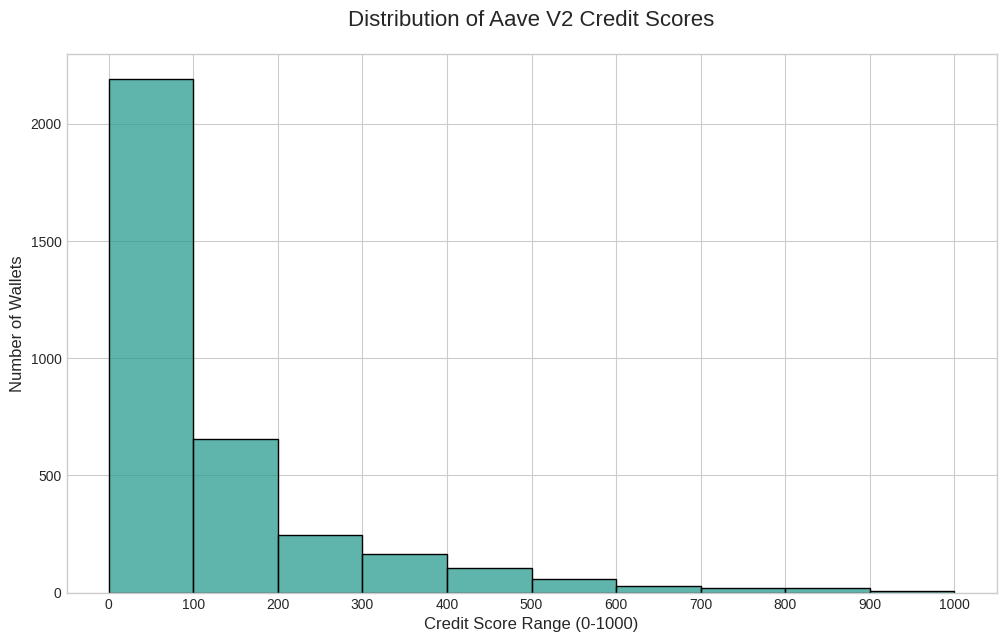


Analyzing the behavior of high-scoring wallets (Score > 800)...
       total_number_of_transactions  wallet_activity_duration_days  \
count                     28.000000                      28.000000   
mean                     455.285714                      86.535714   
std                      263.769520                      40.830709   
min                       47.000000                       2.000000   
25%                      274.500000                      57.000000   
50%                      451.500000                      79.500000   
75%                      650.000000                     122.750000   
max                     1089.000000                     153.000000   

       has_been_liquidated_flag  loan_to_value_ratio  \
count                 28.000000            28.000000   
mean                   0.178571             0.785580   
std                    0.390021             0.818866   
min                    0.000000             0.008246   
25%                    0

In [25]:
print("\n--- Starting Visual Analysis for analysis.md ---")

# 1. Score Distribution Graph
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

sns.histplot(final_results['creditScore'], bins=10, kde=False, color='#2a9d8f', ax=ax)

ax.set_title('Distribution of Aave V2 Credit Scores', fontsize=16, pad=20)
ax.set_xlabel('Credit Score Range (0-1000)', fontsize=12)
ax.set_ylabel('Number of Wallets', fontsize=12)
ax.set_xticks(range(0, 1001, 100))

# Save the plot for our documentation.
plt.savefig('score_distribution.png', dpi=300)
print("\nCreated and saved the score distribution graph (score_distribution.png).")
plt.show()


# 2. Behavior of High-Scoring Wallets
print("\nAnalyzing the behavior of high-scoring wallets (Score > 800)...")
high_scorers = final_results[final_results['creditScore'] > 800]
print(high_scorers[['total_number_of_transactions', 'wallet_activity_duration_days', 'has_been_liquidated_flag', 'loan_to_value_ratio', 'repayment_to_borrow_strength']].describe())


# 3. Behavior of Low-Scoring Wallets
print("\nAnalyzing the behavior of low-scoring wallets (Score < 200)...")
low_scorers = final_results[final_results['creditScore'] < 200]
print(low_scorers[['total_number_of_transactions', 'wallet_activity_duration_days', 'has_been_liquidated_flag', 'loan_to_value_ratio', 'repayment_to_borrow_strength']].describe())

In [26]:
# The final deliverable is a clean CSV with just the wallet and its score.
output_file_path = 'wallet_credit_scores.csv'
scored_wallets_df.to_csv(output_file_path, index=False)

print(f"\nFinal scores have been saved to: {output_file_path}")


Final scores have been saved to: wallet_credit_scores.csv
